In [1]:
import numpy as np
import torch
import os
import pickle

from torchvision import datasets, transforms
import torchvision.utils as vutils

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence
from torch.distributions import Categorical
from torchvision.utils import save_image, make_grid

import tensorflow as tf
import time

import matplotlib.pyplot  as plt
import matplotlib.animation as animation
%matplotlib inline

In [2]:
batch_size = 100

# cpu or gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Number Gpus
ngpu = 1

# Number of training epochs
EPOCHS = 50

# Learning rate for optimizers
lr = 0.0002
decay = 0.0001

num_embeddings = 16

out_dim = 64

cuda:0


In [3]:
os.makedirs("models", exist_ok=True)

In [4]:
with open('colored-mnist.pkl', 'rb') as f:
    data = pickle.load(f)

x_train = data['train']
x_test = data['test']

In [5]:
mnist = tf.keras.datasets.mnist

(_, y_train), (_, y_test) = mnist.load_data()

In [6]:
print(x_train.shape[0], y_train.shape[0])

60000 60000


In [7]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, x, y, transform=None):
    assert (x.shape[0] == y.shape[0]), "x and y must have the same length"
    self.x = torch.from_numpy(x).permute(0, 3, 1, 2).float() / 3
    self.y = torch.from_numpy(y).long()

    self.transform = transform
      
  def __getitem__(self, index):
    x = self.x[index]
    y = self.y[index]
    
    if self.transform:
        x = self.transform(x)
        
    return x, y
  
  def __len__(self):
    return len(self.x)

In [8]:
trainset = MyDataset(x_train, y_train)
testset = MyDataset(x_test, y_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [9]:
fixed_images, _ = next(iter(test_loader))
fixed_grid = make_grid(fixed_images.cpu(), nrow=10, normalize=True)
print("batch shape:", fixed_images.shape)

batch shape: torch.Size([100, 3, 28, 28])


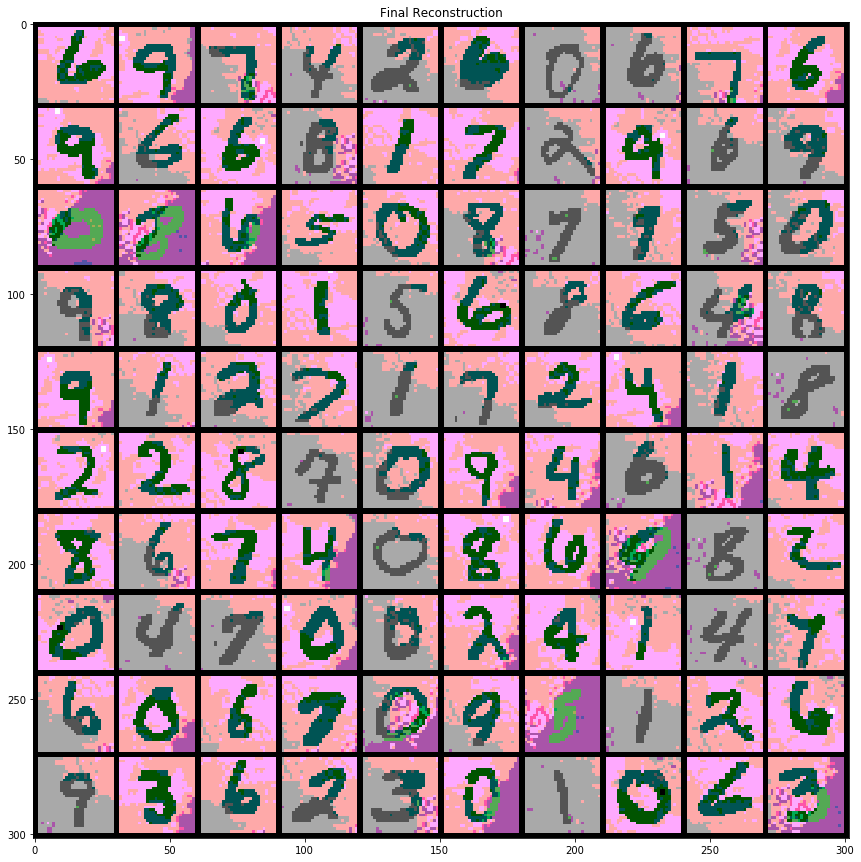

In [13]:
fig = plt.figure(figsize=(15,15))
plt.imshow(np.transpose(fixed_grid, (1,2,0)))
plt.title("Final Reconstruction")
plt.show()

# VQ-VAE

In [19]:
class ResBlock(nn.Module):
    
    def __init__(self, in_channels, hidden_channels, use_batch_norm=True):
        super().__init__()
        if use_batch_norm:
            self.block = nn.Sequential(
              nn.ReLU(True),
              nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
              nn.BatchNorm2d(hidden_channels),
              nn.ReLU(True),
              nn.Conv2d(hidden_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=False),
              nn.BatchNorm2d(in_channels)
            )
        else:
            self.block = nn.Sequential(
              nn.ReLU(True),
              nn.Conv2d(in_channels, hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
              nn.ReLU(True),
              nn.Conv2d(hidden_channels, in_channels, kernel_size=1, stride=1, padding=0, bias=False),
            )

    def forward(self, x):
        return x + self.block(x)

In [20]:
class VQ(nn.Module):
    
  def __init__(self, num_embeddings, embedding_size, commitment_cost=0.25):
    super().__init__()
    self.num_embeddings = num_embeddings
    self.embedding_size = embedding_size
    self.commitment_cost = commitment_cost
    
    self.embedding = nn.Embedding(num_embeddings, embedding_size)
    self.embedding.weight.data.uniform_(-1. / num_embeddings, 1. / num_embeddings)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()  # from BCHW to BHWC
    x_flat = x.view(-1, self.embedding_size)
    
    w = self.embedding.weight
    distances = torch.sum(x_flat ** 2, dim=1, keepdim=True) + torch.sum(w ** 2, dim=1) - 2 * (x_flat @ w.T)
    indices_flat = torch.argmin(distances, dim=1, keepdim=True)
    quantized_flat = self.embed(indices_flat)
    
    quantized = quantized_flat.view(x.shape)
    indices = indices_flat.view(*x.shape[:3]).unsqueeze(dim=1)  # BHW to BCHW


    if self.training:
      e_latent_loss = F.mse_loss(quantized.detach(), x)
      q_latent_loss = F.mse_loss(quantized, x.detach())
      loss = q_latent_loss + self.commitment_cost * e_latent_loss
  
      quantized = x + (quantized - x).detach()
    else:
      loss = 0.
    
    quantized = quantized.permute(0, 3, 1, 2).contiguous()  # from BHWC to BCHW
    
    return quantized, indices, loss
  
  def embed(self, indices):
    quantized = self.embedding(indices)
    return quantized

In [21]:
class VQVAE(nn.Module):
    
    def __init__(self, in_channels, num_embeddings, embedding_size=32, res_hidden_channels=32, commitment_cost=0.25):
        super().__init__()
        self.in_channels = in_channels
        self.num_embeddings = num_embeddings
        self.embedding_size = embedding_size
        
        h = embedding_size
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, h, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h),
            nn.ReLU(inplace=True),
            nn.Conv2d(h, h, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(h),
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels),
            ResBlock(h, res_hidden_channels)
        )
        
        self.vq = VQ(num_embeddings, embedding_size, commitment_cost)
        
        self.decoder = nn.Sequential(
            ResBlock(h, res_hidden_channels, use_batch_norm=False),
            ResBlock(h, res_hidden_channels, use_batch_norm=False),
            ResBlock(h, res_hidden_channels, use_batch_norm=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(h, h, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(h, in_channels, kernel_size=4, stride=2, padding=1)
        )
       
    def forward(self, x):
        z = self.encode(x)
        quantized, indices, vq_loss = self.quantize(z)
        x_recon = self.decode(quantized)
        return x_recon, quantized, indices, vq_loss
    
    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def quantize(self, z):
        quantized, indices, vq_loss = self.vq(z)
        return quantized, indices, vq_loss
    
    def decode(self, quantized):
        x_recon = self.decoder(quantized)
        return x_recon
    
    def embed(self, indices):
        return self.vq.embed(indices)


In [22]:
def generate_samples(images, model):
  with torch.no_grad():
    images = images.to(device)
    x_recon, _, _, _ = model(images)
  return x_recon

# Train VQ-VAE

In [23]:
vq_vae = VQVAE(3, 128, num_embeddings).to(device)
optimizer = torch.optim.Adam(vq_vae.parameters(), lr=lr, weight_decay=decay)

[0/50][99/600]	 loss: 4.5046	 val_loss: 4.5088	
[0/50][199/600]	 loss: 3.2994	 val_loss: 3.2881	
[0/50][299/600]	 loss: 2.2979	 val_loss: 2.2918	
[0/50][399/600]	 loss: 1.9482	 val_loss: 1.9435	
[0/50][499/600]	 loss: 1.4796	 val_loss: 1.4765	
[0/50][599/600]	 loss: 1.2357	 val_loss: 1.2347	
[1/50][99/600]	 loss: 1.0401	 val_loss: 1.0393	
[1/50][199/600]	 loss: 0.8312	 val_loss: 0.8295	
[1/50][299/600]	 loss: 0.6572	 val_loss: 0.6554	
[1/50][399/600]	 loss: 0.5729	 val_loss: 0.5718	
[1/50][499/600]	 loss: 0.4584	 val_loss: 0.4570	
[1/50][599/600]	 loss: 0.3681	 val_loss: 0.3675	


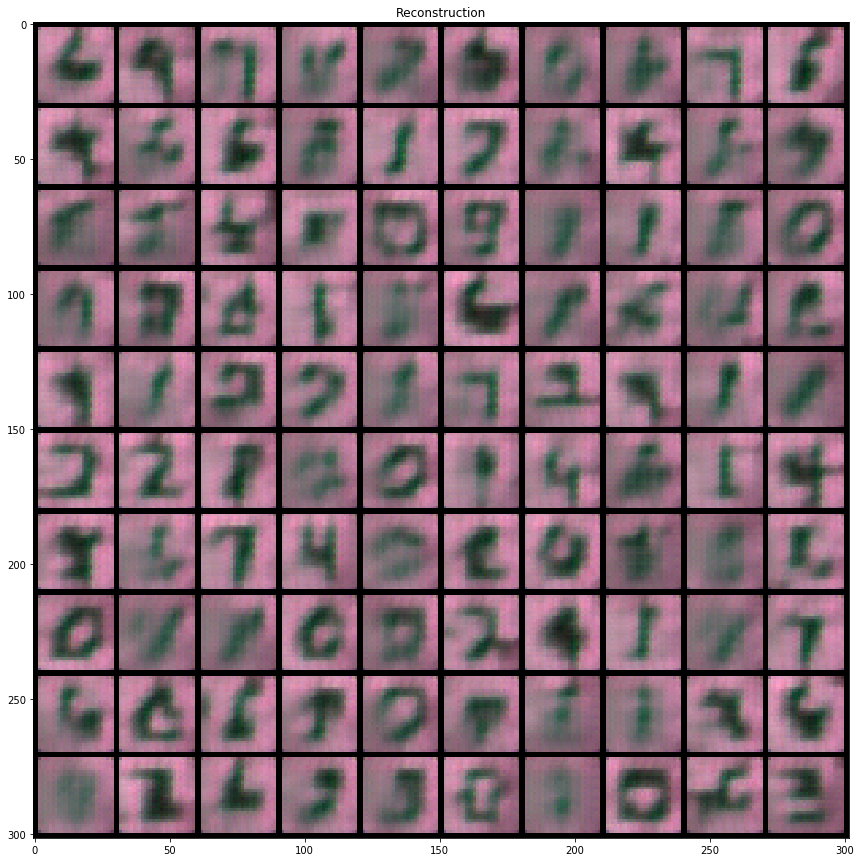

[2/50][99/600]	 loss: 0.3025	 val_loss: 0.3020	
[2/50][199/600]	 loss: 0.2435	 val_loss: 0.2430	
[2/50][299/600]	 loss: 0.2090	 val_loss: 0.2088	
[2/50][399/600]	 loss: 0.1854	 val_loss: 0.1853	
[2/50][499/600]	 loss: 0.1574	 val_loss: 0.1571	
[2/50][599/600]	 loss: 0.1440	 val_loss: 0.1435	
[3/50][99/600]	 loss: 0.1291	 val_loss: 0.1290	
[3/50][199/600]	 loss: 0.1163	 val_loss: 0.1162	
[3/50][299/600]	 loss: 0.1047	 val_loss: 0.1045	
[3/50][399/600]	 loss: 0.1047	 val_loss: 0.1046	
[3/50][499/600]	 loss: 0.0939	 val_loss: 0.0938	
[3/50][599/600]	 loss: 0.0855	 val_loss: 0.0852	


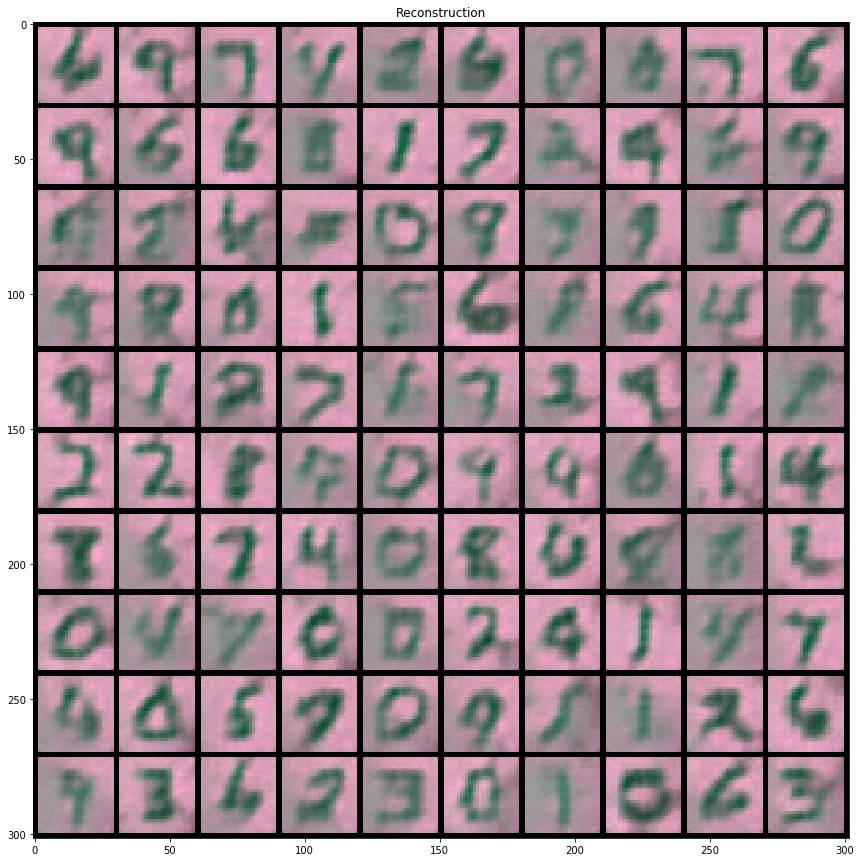

[4/50][99/600]	 loss: 0.0783	 val_loss: 0.0782	
[4/50][199/600]	 loss: 0.0752	 val_loss: 0.0750	
[4/50][299/600]	 loss: 0.0676	 val_loss: 0.0675	
[4/50][399/600]	 loss: 0.0661	 val_loss: 0.0661	
[4/50][499/600]	 loss: 0.0578	 val_loss: 0.0577	
[4/50][599/600]	 loss: 0.0558	 val_loss: 0.0557	
[5/50][99/600]	 loss: 0.0560	 val_loss: 0.0559	
[5/50][199/600]	 loss: 0.0513	 val_loss: 0.0513	
[5/50][299/600]	 loss: 0.0497	 val_loss: 0.0496	
[5/50][399/600]	 loss: 0.0498	 val_loss: 0.0494	
[5/50][499/600]	 loss: 0.0454	 val_loss: 0.0452	
[5/50][599/600]	 loss: 0.0429	 val_loss: 0.0429	


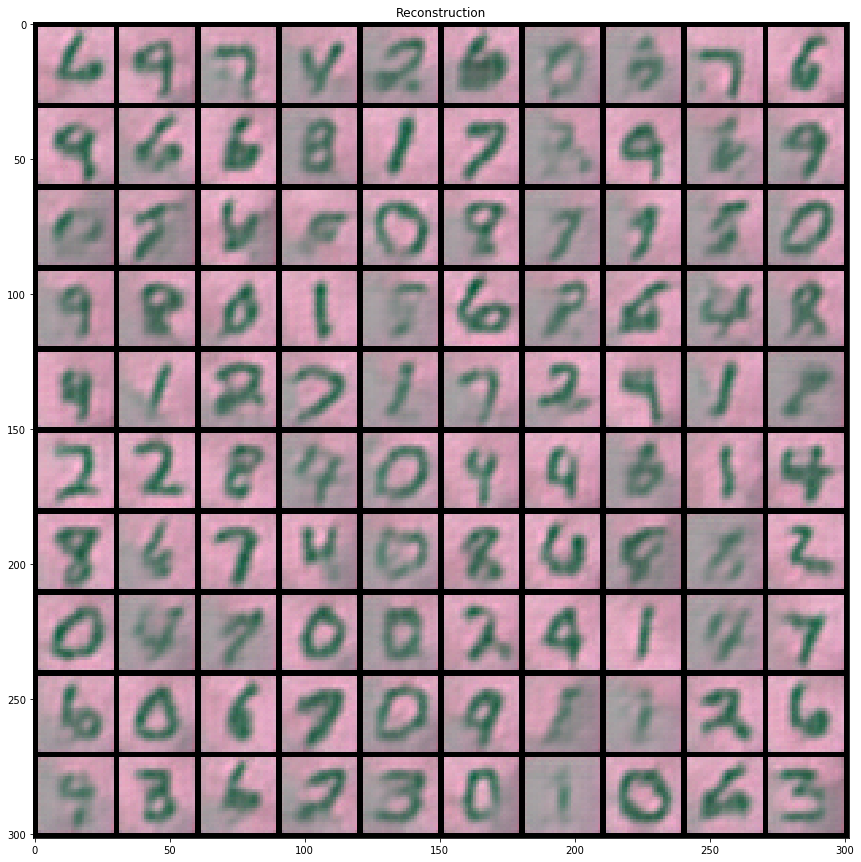

[6/50][99/600]	 loss: 0.0417	 val_loss: 0.0415	
[6/50][199/600]	 loss: 0.0433	 val_loss: 0.0434	
[6/50][299/600]	 loss: 0.0428	 val_loss: 0.0428	
[6/50][399/600]	 loss: 0.0381	 val_loss: 0.0380	
[6/50][499/600]	 loss: 0.0409	 val_loss: 0.0408	
[6/50][599/600]	 loss: 0.0383	 val_loss: 0.0381	
[7/50][99/600]	 loss: 0.0372	 val_loss: 0.0371	
[7/50][199/600]	 loss: 0.0358	 val_loss: 0.0358	
[7/50][299/600]	 loss: 0.0364	 val_loss: 0.0363	
[7/50][399/600]	 loss: 0.0357	 val_loss: 0.0355	
[7/50][499/600]	 loss: 0.0338	 val_loss: 0.0338	
[7/50][599/600]	 loss: 0.0340	 val_loss: 0.0340	


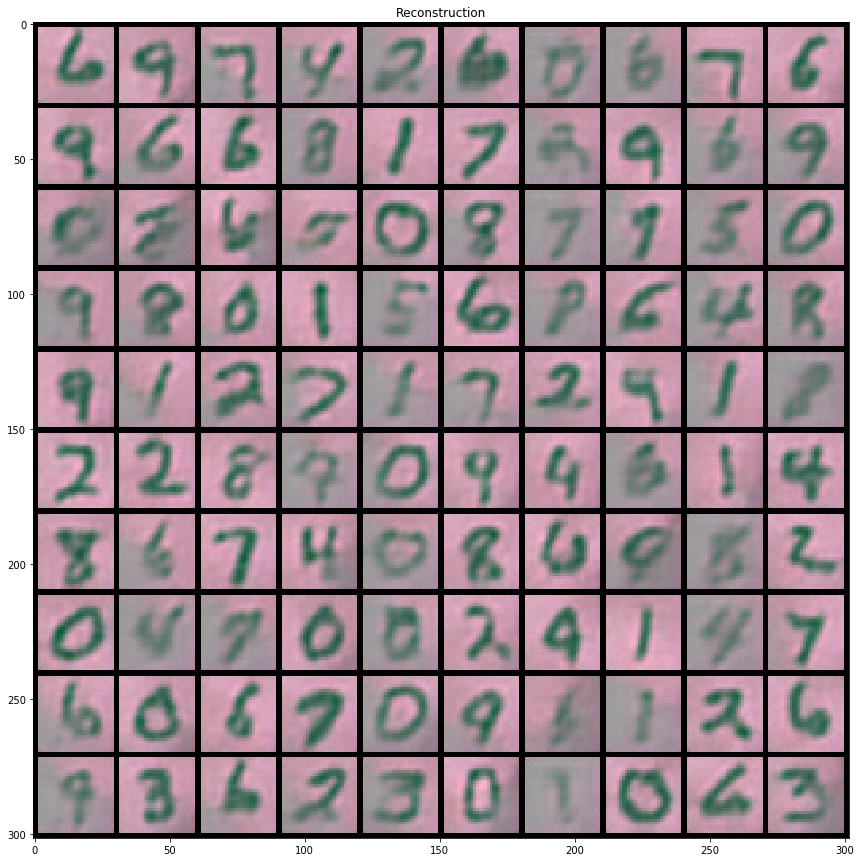

[8/50][99/600]	 loss: 0.0318	 val_loss: 0.0318	
[8/50][199/600]	 loss: 0.0308	 val_loss: 0.0308	
[8/50][299/600]	 loss: 0.0323	 val_loss: 0.0323	
[8/50][399/600]	 loss: 0.0344	 val_loss: 0.0344	
[8/50][499/600]	 loss: 0.0317	 val_loss: 0.0316	
[8/50][599/600]	 loss: 0.0323	 val_loss: 0.0321	
[9/50][99/600]	 loss: 0.0318	 val_loss: 0.0317	
[9/50][199/600]	 loss: 0.0321	 val_loss: 0.0322	
[9/50][299/600]	 loss: 0.0316	 val_loss: 0.0316	
[9/50][399/600]	 loss: 0.0319	 val_loss: 0.0318	
[9/50][499/600]	 loss: 0.0303	 val_loss: 0.0303	
[9/50][599/600]	 loss: 0.0316	 val_loss: 0.0315	


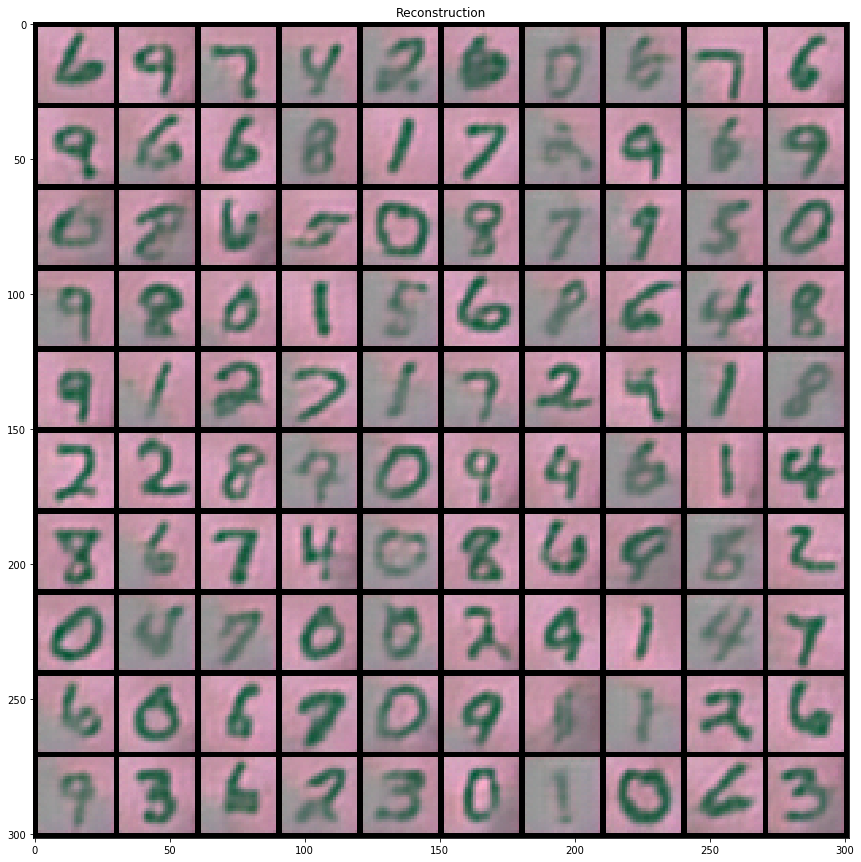

[10/50][99/600]	 loss: 0.0321	 val_loss: 0.0321	
[10/50][199/600]	 loss: 0.0311	 val_loss: 0.0311	
[10/50][299/600]	 loss: 0.0307	 val_loss: 0.0307	
[10/50][399/600]	 loss: 0.0291	 val_loss: 0.0291	
[10/50][499/600]	 loss: 0.0294	 val_loss: 0.0293	
[10/50][599/600]	 loss: 0.0303	 val_loss: 0.0304	
[11/50][99/600]	 loss: 0.0314	 val_loss: 0.0312	
[11/50][199/600]	 loss: 0.0301	 val_loss: 0.0300	
[11/50][299/600]	 loss: 0.0305	 val_loss: 0.0306	
[11/50][399/600]	 loss: 0.0296	 val_loss: 0.0297	
[11/50][499/600]	 loss: 0.0294	 val_loss: 0.0293	
[11/50][599/600]	 loss: 0.0276	 val_loss: 0.0275	


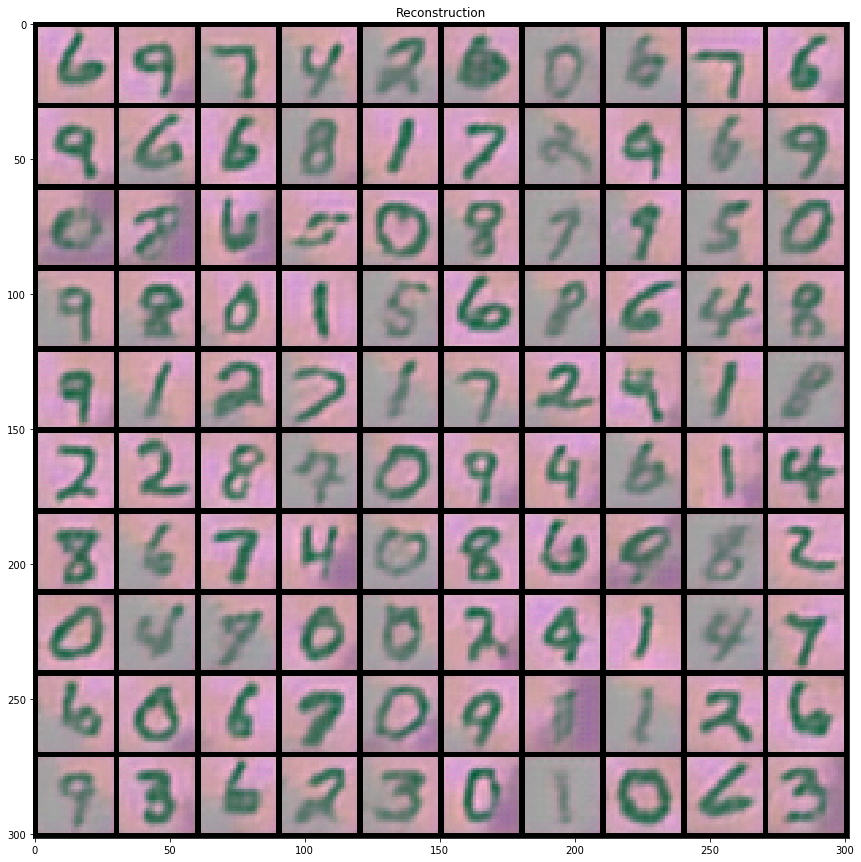

[12/50][99/600]	 loss: 0.0284	 val_loss: 0.0283	
[12/50][199/600]	 loss: 0.0278	 val_loss: 0.0278	
[12/50][299/600]	 loss: 0.0285	 val_loss: 0.0285	
[12/50][399/600]	 loss: 0.0277	 val_loss: 0.0277	
[12/50][499/600]	 loss: 0.0266	 val_loss: 0.0266	
[12/50][599/600]	 loss: 0.0274	 val_loss: 0.0274	
[13/50][99/600]	 loss: 0.0262	 val_loss: 0.0262	
[13/50][199/600]	 loss: 0.0277	 val_loss: 0.0276	
[13/50][299/600]	 loss: 0.0276	 val_loss: 0.0275	
[13/50][399/600]	 loss: 0.0273	 val_loss: 0.0273	
[13/50][499/600]	 loss: 0.0280	 val_loss: 0.0280	
[13/50][599/600]	 loss: 0.0268	 val_loss: 0.0267	


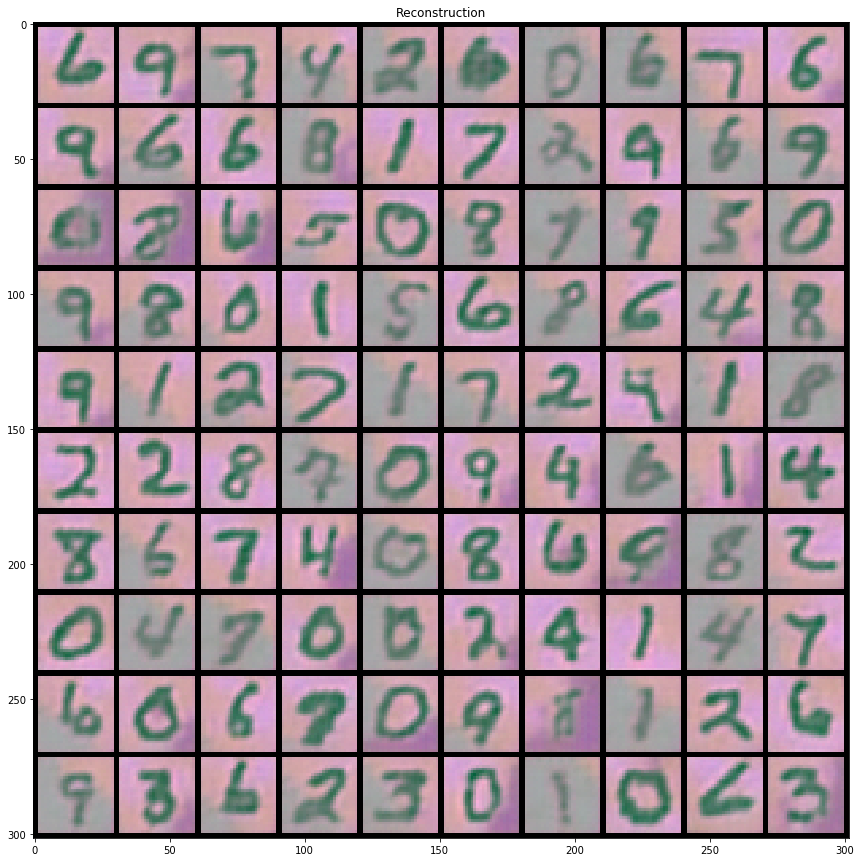

[14/50][99/600]	 loss: 0.0260	 val_loss: 0.0261	
[14/50][199/600]	 loss: 0.0266	 val_loss: 0.0265	
[14/50][299/600]	 loss: 0.0262	 val_loss: 0.0262	
[14/50][399/600]	 loss: 0.0281	 val_loss: 0.0281	
[14/50][499/600]	 loss: 0.0254	 val_loss: 0.0253	
[14/50][599/600]	 loss: 0.0267	 val_loss: 0.0267	
[15/50][99/600]	 loss: 0.0254	 val_loss: 0.0254	
[15/50][199/600]	 loss: 0.0255	 val_loss: 0.0254	
[15/50][299/600]	 loss: 0.0266	 val_loss: 0.0267	
[15/50][399/600]	 loss: 0.0259	 val_loss: 0.0258	
[15/50][499/600]	 loss: 0.0261	 val_loss: 0.0260	
[15/50][599/600]	 loss: 0.0250	 val_loss: 0.0251	


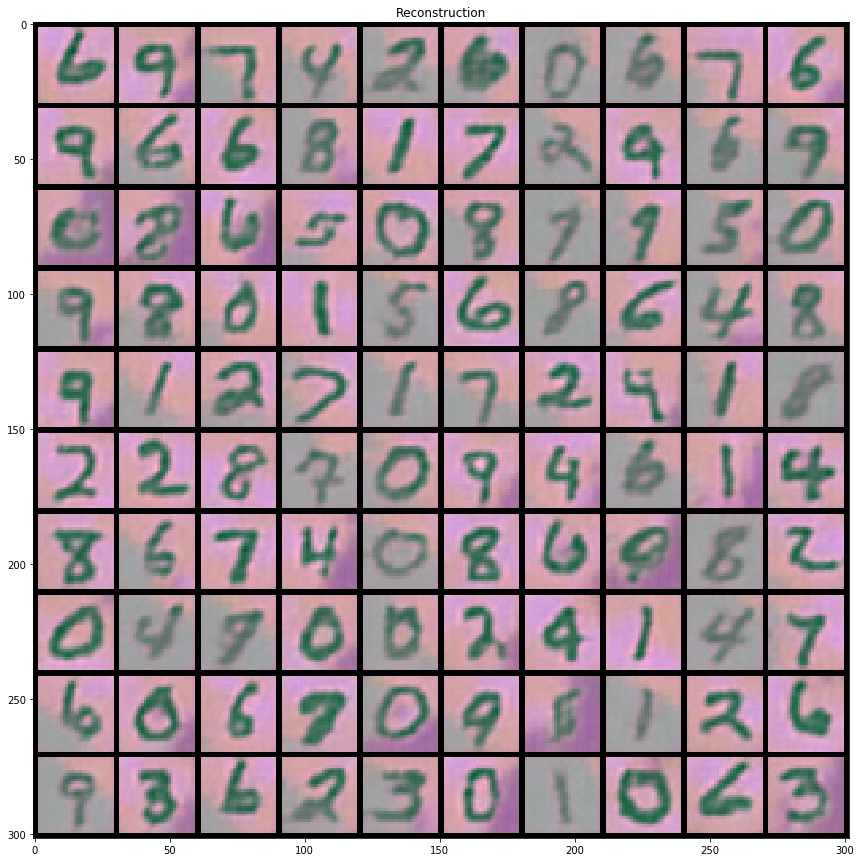

[16/50][99/600]	 loss: 0.0268	 val_loss: 0.0269	
[16/50][199/600]	 loss: 0.0262	 val_loss: 0.0263	
[16/50][299/600]	 loss: 0.0274	 val_loss: 0.0276	
[16/50][399/600]	 loss: 0.0253	 val_loss: 0.0253	
[16/50][499/600]	 loss: 0.0265	 val_loss: 0.0264	
[16/50][599/600]	 loss: 0.0264	 val_loss: 0.0261	
[17/50][99/600]	 loss: 0.0258	 val_loss: 0.0258	
[17/50][199/600]	 loss: 0.0253	 val_loss: 0.0252	
[17/50][299/600]	 loss: 0.0263	 val_loss: 0.0263	
[17/50][399/600]	 loss: 0.0251	 val_loss: 0.0251	
[17/50][499/600]	 loss: 0.0260	 val_loss: 0.0260	
[17/50][599/600]	 loss: 0.0245	 val_loss: 0.0245	


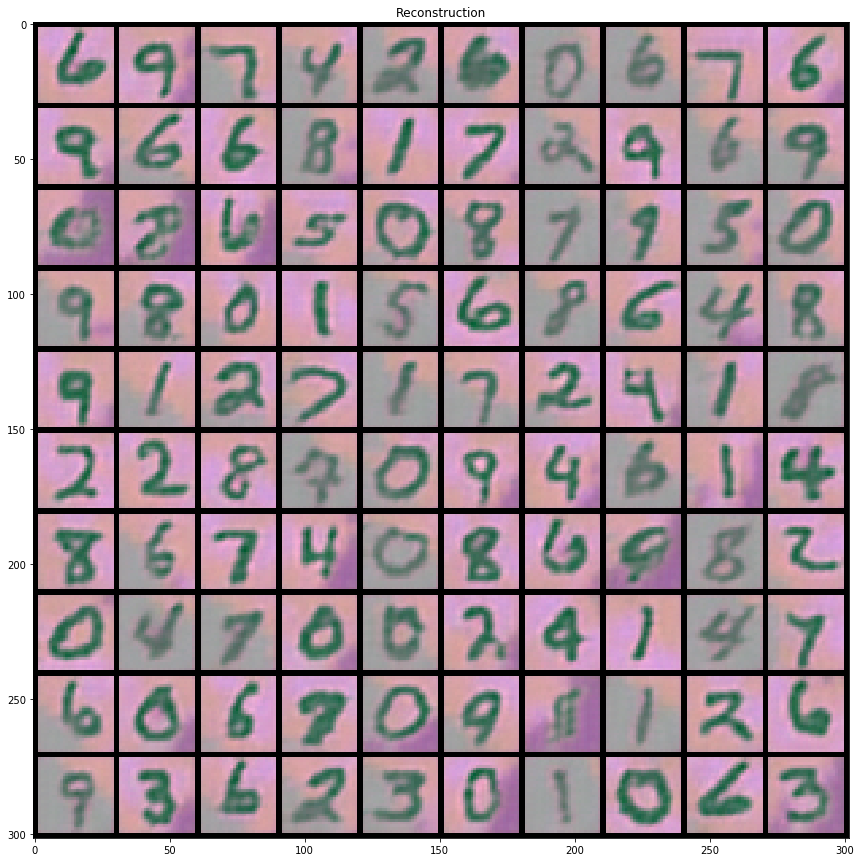

[18/50][99/600]	 loss: 0.0251	 val_loss: 0.0250	
[18/50][199/600]	 loss: 0.0268	 val_loss: 0.0265	
[18/50][299/600]	 loss: 0.0253	 val_loss: 0.0250	
[18/50][399/600]	 loss: 0.0257	 val_loss: 0.0257	
[18/50][499/600]	 loss: 0.0255	 val_loss: 0.0256	
[18/50][599/600]	 loss: 0.0259	 val_loss: 0.0259	
[19/50][99/600]	 loss: 0.0247	 val_loss: 0.0246	
[19/50][199/600]	 loss: 0.0249	 val_loss: 0.0248	
[19/50][299/600]	 loss: 0.0255	 val_loss: 0.0256	
[19/50][399/600]	 loss: 0.0250	 val_loss: 0.0251	
[19/50][499/600]	 loss: 0.0242	 val_loss: 0.0241	
[19/50][599/600]	 loss: 0.0241	 val_loss: 0.0240	


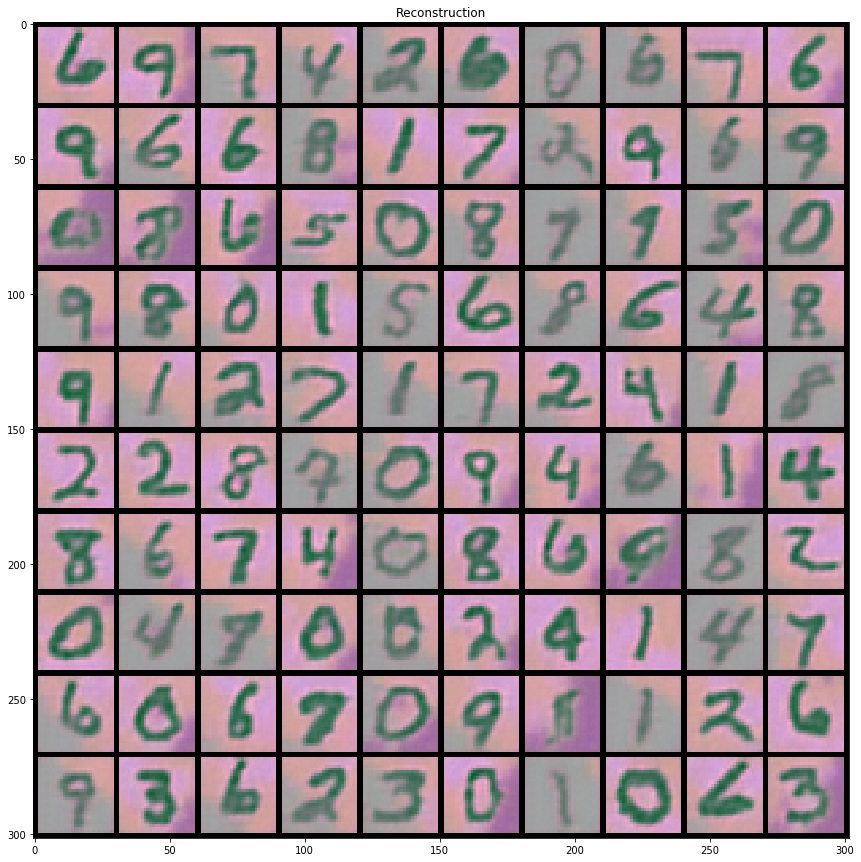

[20/50][99/600]	 loss: 0.0252	 val_loss: 0.0252	
[20/50][199/600]	 loss: 0.0234	 val_loss: 0.0234	
[20/50][299/600]	 loss: 0.0248	 val_loss: 0.0249	
[20/50][399/600]	 loss: 0.0259	 val_loss: 0.0259	
[20/50][499/600]	 loss: 0.0245	 val_loss: 0.0244	
[20/50][599/600]	 loss: 0.0251	 val_loss: 0.0251	
[21/50][99/600]	 loss: 0.0241	 val_loss: 0.0243	
[21/50][199/600]	 loss: 0.0238	 val_loss: 0.0237	
[21/50][299/600]	 loss: 0.0230	 val_loss: 0.0229	
[21/50][399/600]	 loss: 0.0257	 val_loss: 0.0254	
[21/50][499/600]	 loss: 0.0243	 val_loss: 0.0242	
[21/50][599/600]	 loss: 0.0238	 val_loss: 0.0237	


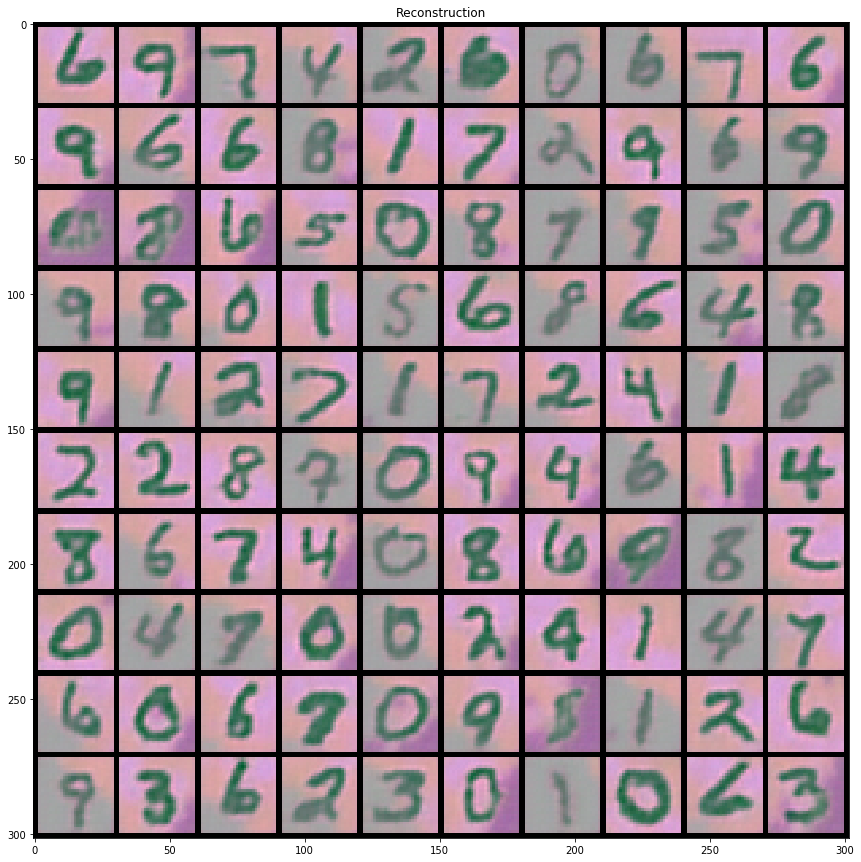

[22/50][99/600]	 loss: 0.0249	 val_loss: 0.0249	
[22/50][199/600]	 loss: 0.0256	 val_loss: 0.0257	
[22/50][299/600]	 loss: 0.0247	 val_loss: 0.0246	
[22/50][399/600]	 loss: 0.0242	 val_loss: 0.0243	
[22/50][499/600]	 loss: 0.0237	 val_loss: 0.0236	
[22/50][599/600]	 loss: 0.0252	 val_loss: 0.0251	
[23/50][99/600]	 loss: 0.0242	 val_loss: 0.0242	
[23/50][199/600]	 loss: 0.0239	 val_loss: 0.0240	
[23/50][299/600]	 loss: 0.0243	 val_loss: 0.0244	
[23/50][399/600]	 loss: 0.0233	 val_loss: 0.0234	
[23/50][499/600]	 loss: 0.0251	 val_loss: 0.0252	
[23/50][599/600]	 loss: 0.0240	 val_loss: 0.0241	


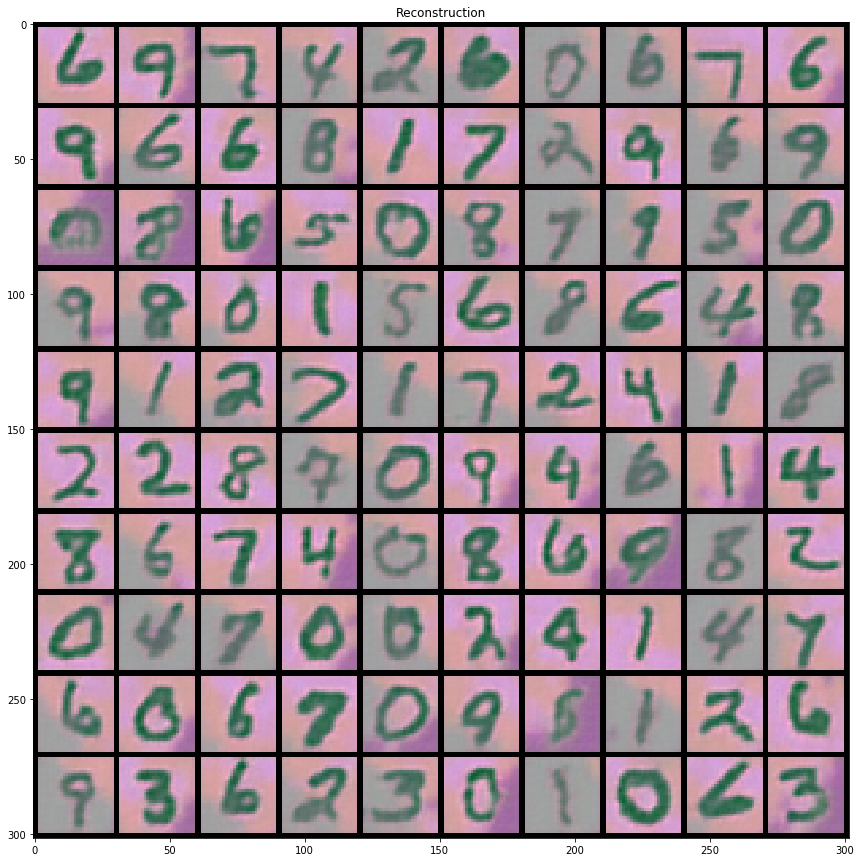

[24/50][99/600]	 loss: 0.0240	 val_loss: 0.0241	
[24/50][199/600]	 loss: 0.0243	 val_loss: 0.0241	
[24/50][299/600]	 loss: 0.0250	 val_loss: 0.0249	
[24/50][399/600]	 loss: 0.0242	 val_loss: 0.0242	
[24/50][499/600]	 loss: 0.0242	 val_loss: 0.0243	
[24/50][599/600]	 loss: 0.0238	 val_loss: 0.0237	
[25/50][99/600]	 loss: 0.0240	 val_loss: 0.0241	
[25/50][199/600]	 loss: 0.0242	 val_loss: 0.0241	
[25/50][299/600]	 loss: 0.0249	 val_loss: 0.0250	
[25/50][399/600]	 loss: 0.0244	 val_loss: 0.0243	
[25/50][499/600]	 loss: 0.0237	 val_loss: 0.0237	
[25/50][599/600]	 loss: 0.0239	 val_loss: 0.0238	


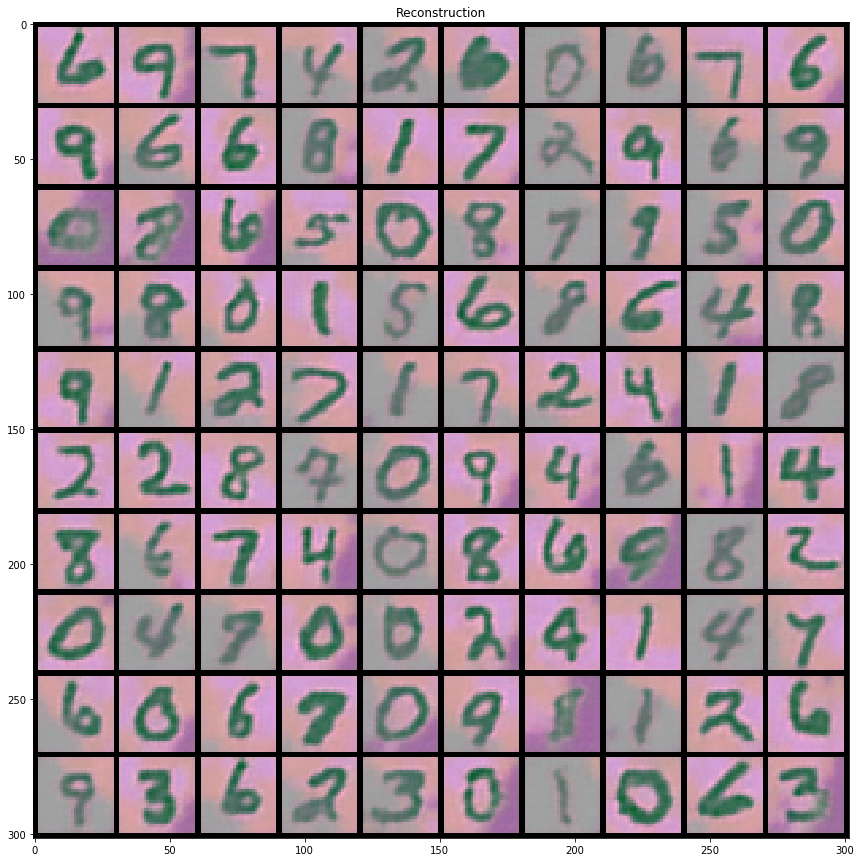

[26/50][99/600]	 loss: 0.0242	 val_loss: 0.0242	
[26/50][199/600]	 loss: 0.0254	 val_loss: 0.0256	
[26/50][299/600]	 loss: 0.0238	 val_loss: 0.0236	
[26/50][399/600]	 loss: 0.0233	 val_loss: 0.0233	
[26/50][499/600]	 loss: 0.0241	 val_loss: 0.0240	
[26/50][599/600]	 loss: 0.0235	 val_loss: 0.0234	
[27/50][99/600]	 loss: 0.0248	 val_loss: 0.0246	
[27/50][199/600]	 loss: 0.0242	 val_loss: 0.0242	
[27/50][299/600]	 loss: 0.0229	 val_loss: 0.0227	
[27/50][399/600]	 loss: 0.0243	 val_loss: 0.0243	
[27/50][499/600]	 loss: 0.0238	 val_loss: 0.0238	
[27/50][599/600]	 loss: 0.0233	 val_loss: 0.0232	


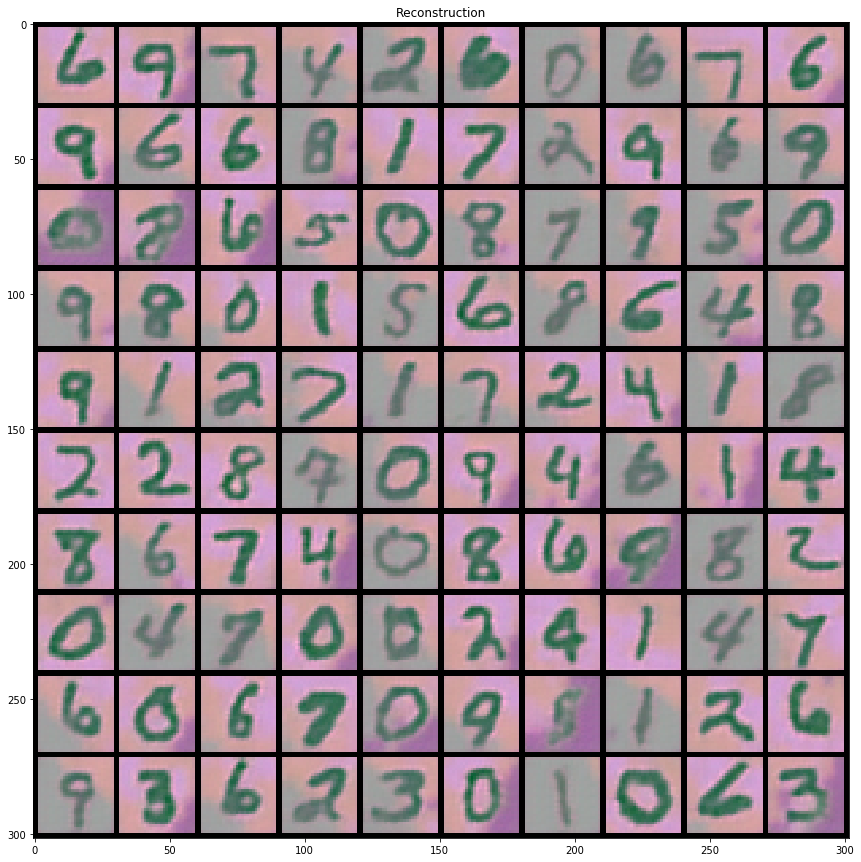

[28/50][99/600]	 loss: 0.0229	 val_loss: 0.0227	
[28/50][199/600]	 loss: 0.0245	 val_loss: 0.0245	
[28/50][299/600]	 loss: 0.0246	 val_loss: 0.0246	
[28/50][399/600]	 loss: 0.0247	 val_loss: 0.0246	
[28/50][499/600]	 loss: 0.0232	 val_loss: 0.0231	
[28/50][599/600]	 loss: 0.0237	 val_loss: 0.0237	
[29/50][99/600]	 loss: 0.0232	 val_loss: 0.0232	
[29/50][199/600]	 loss: 0.0231	 val_loss: 0.0232	
[29/50][299/600]	 loss: 0.0233	 val_loss: 0.0233	
[29/50][399/600]	 loss: 0.0219	 val_loss: 0.0221	
[29/50][499/600]	 loss: 0.0224	 val_loss: 0.0225	
[29/50][599/600]	 loss: 0.0225	 val_loss: 0.0222	


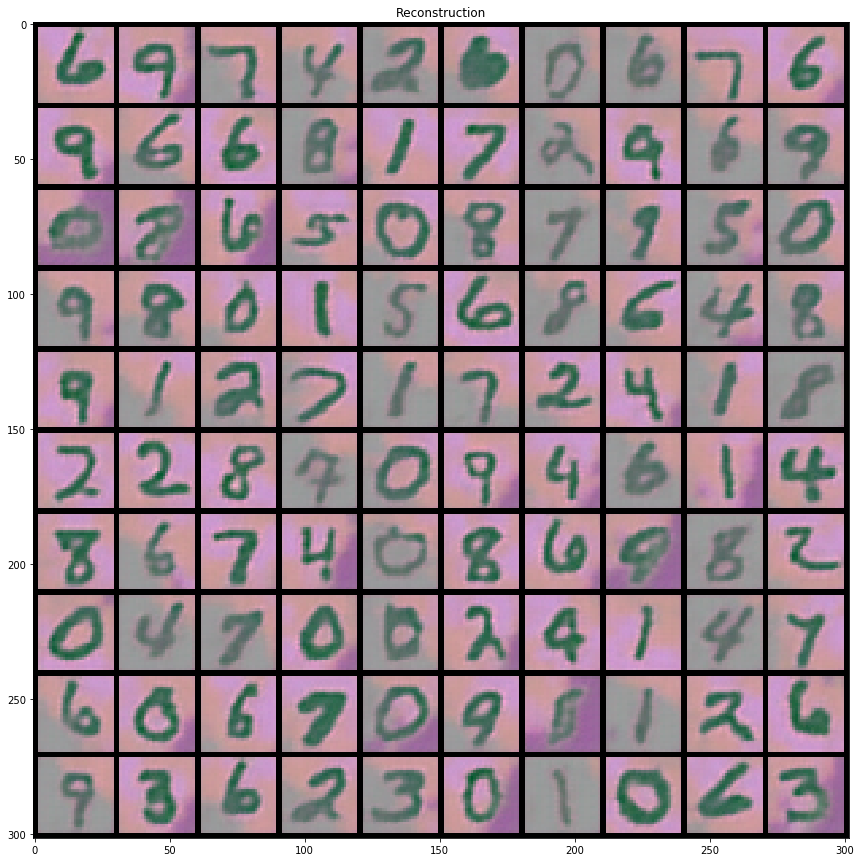

[30/50][99/600]	 loss: 0.0229	 val_loss: 0.0229	
[30/50][199/600]	 loss: 0.0228	 val_loss: 0.0228	
[30/50][299/600]	 loss: 0.0238	 val_loss: 0.0240	
[30/50][399/600]	 loss: 0.0223	 val_loss: 0.0224	
[30/50][499/600]	 loss: 0.0235	 val_loss: 0.0237	
[30/50][599/600]	 loss: 0.0236	 val_loss: 0.0236	
[31/50][99/600]	 loss: 0.0232	 val_loss: 0.0231	
[31/50][199/600]	 loss: 0.0223	 val_loss: 0.0222	
[31/50][299/600]	 loss: 0.0220	 val_loss: 0.0217	
[31/50][399/600]	 loss: 0.0218	 val_loss: 0.0218	
[31/50][499/600]	 loss: 0.0233	 val_loss: 0.0232	
[31/50][599/600]	 loss: 0.0237	 val_loss: 0.0235	


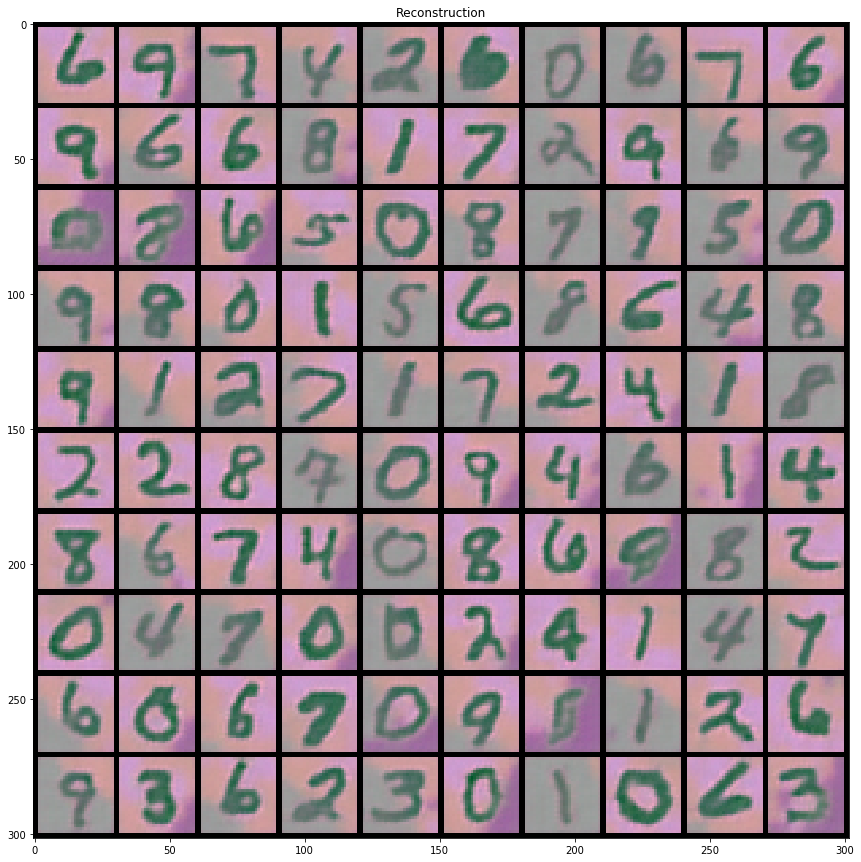

[32/50][99/600]	 loss: 0.0223	 val_loss: 0.0222	
[32/50][199/600]	 loss: 0.0220	 val_loss: 0.0218	
[32/50][299/600]	 loss: 0.0220	 val_loss: 0.0219	
[32/50][399/600]	 loss: 0.0225	 val_loss: 0.0226	
[32/50][499/600]	 loss: 0.0225	 val_loss: 0.0224	
[32/50][599/600]	 loss: 0.0223	 val_loss: 0.0222	
[33/50][99/600]	 loss: 0.0234	 val_loss: 0.0233	
[33/50][199/600]	 loss: 0.0225	 val_loss: 0.0226	
[33/50][299/600]	 loss: 0.0226	 val_loss: 0.0227	
[33/50][399/600]	 loss: 0.0219	 val_loss: 0.0218	
[33/50][499/600]	 loss: 0.0221	 val_loss: 0.0220	
[33/50][599/600]	 loss: 0.0222	 val_loss: 0.0222	


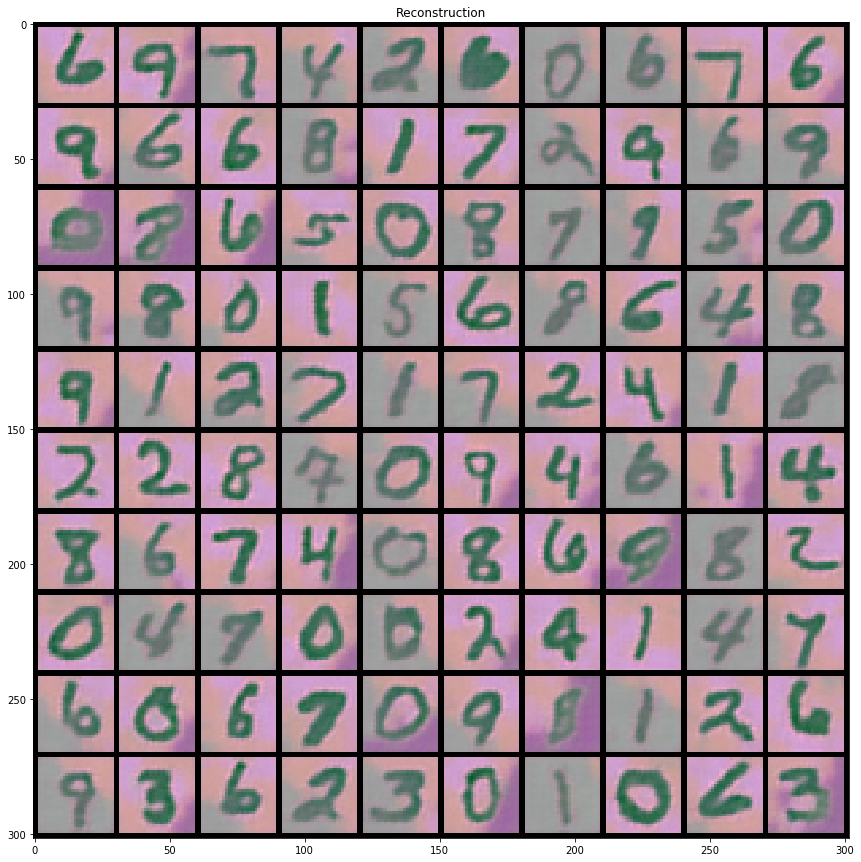

[34/50][99/600]	 loss: 0.0223	 val_loss: 0.0221	
[34/50][199/600]	 loss: 0.0223	 val_loss: 0.0222	
[34/50][299/600]	 loss: 0.0231	 val_loss: 0.0230	
[34/50][399/600]	 loss: 0.0224	 val_loss: 0.0224	
[34/50][499/600]	 loss: 0.0231	 val_loss: 0.0232	
[34/50][599/600]	 loss: 0.0225	 val_loss: 0.0223	
[35/50][99/600]	 loss: 0.0222	 val_loss: 0.0221	
[35/50][199/600]	 loss: 0.0229	 val_loss: 0.0230	
[35/50][299/600]	 loss: 0.0228	 val_loss: 0.0228	
[35/50][399/600]	 loss: 0.0233	 val_loss: 0.0233	
[35/50][499/600]	 loss: 0.0214	 val_loss: 0.0214	
[35/50][599/600]	 loss: 0.0222	 val_loss: 0.0220	


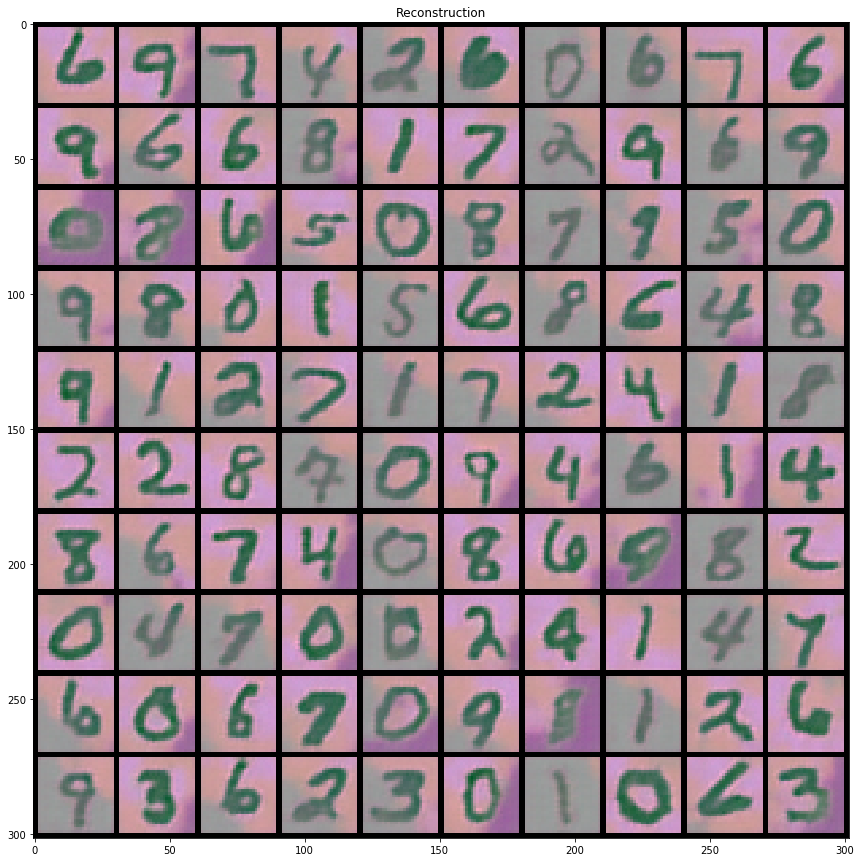

[36/50][99/600]	 loss: 0.0225	 val_loss: 0.0226	
[36/50][199/600]	 loss: 0.0228	 val_loss: 0.0227	
[36/50][299/600]	 loss: 0.0228	 val_loss: 0.0227	
[36/50][399/600]	 loss: 0.0219	 val_loss: 0.0219	
[36/50][499/600]	 loss: 0.0235	 val_loss: 0.0235	
[36/50][599/600]	 loss: 0.0228	 val_loss: 0.0228	
[37/50][99/600]	 loss: 0.0227	 val_loss: 0.0228	
[37/50][199/600]	 loss: 0.0219	 val_loss: 0.0218	
[37/50][299/600]	 loss: 0.0218	 val_loss: 0.0216	
[37/50][399/600]	 loss: 0.0225	 val_loss: 0.0225	
[37/50][499/600]	 loss: 0.0230	 val_loss: 0.0228	
[37/50][599/600]	 loss: 0.0223	 val_loss: 0.0223	


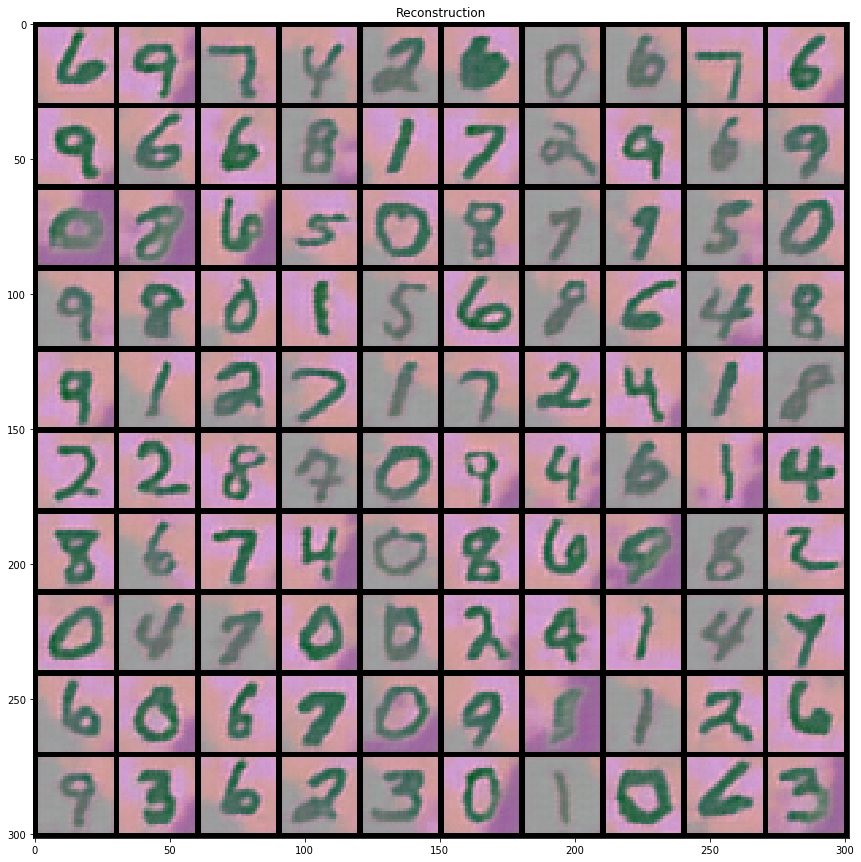

[38/50][99/600]	 loss: 0.0220	 val_loss: 0.0220	
[38/50][199/600]	 loss: 0.0215	 val_loss: 0.0215	
[38/50][299/600]	 loss: 0.0232	 val_loss: 0.0233	
[38/50][399/600]	 loss: 0.0212	 val_loss: 0.0212	
[38/50][499/600]	 loss: 0.0217	 val_loss: 0.0216	
[38/50][599/600]	 loss: 0.0217	 val_loss: 0.0217	
[39/50][99/600]	 loss: 0.0210	 val_loss: 0.0210	
[39/50][199/600]	 loss: 0.0213	 val_loss: 0.0210	
[39/50][299/600]	 loss: 0.0226	 val_loss: 0.0225	
[39/50][399/600]	 loss: 0.0215	 val_loss: 0.0215	
[39/50][499/600]	 loss: 0.0213	 val_loss: 0.0213	
[39/50][599/600]	 loss: 0.0211	 val_loss: 0.0210	


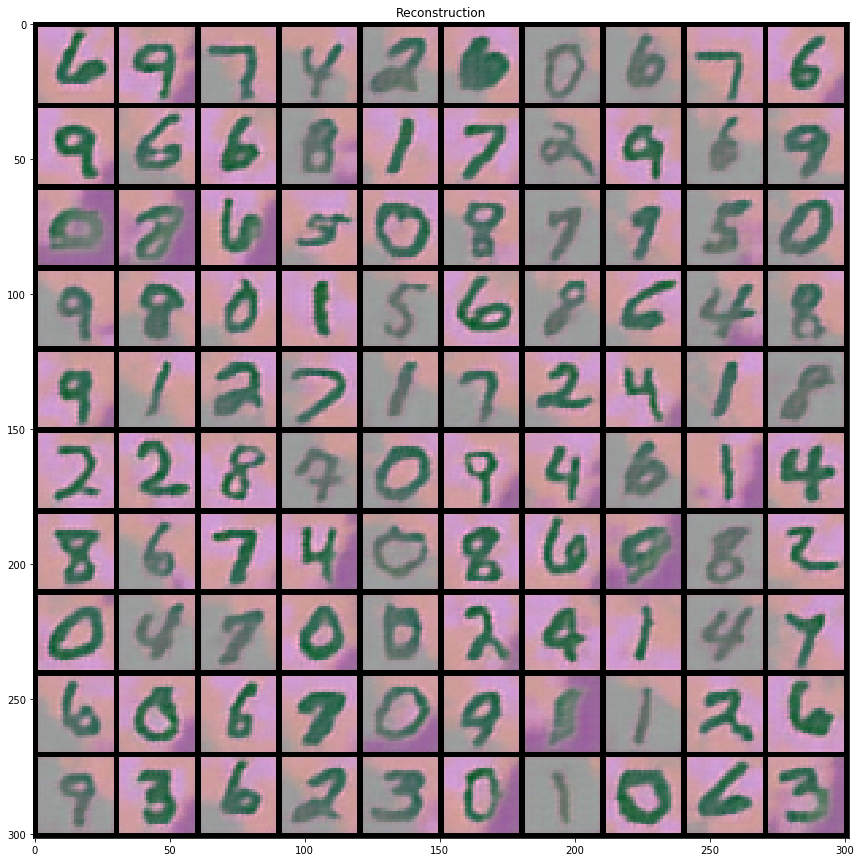

[40/50][99/600]	 loss: 0.0217	 val_loss: 0.0216	
[40/50][199/600]	 loss: 0.0209	 val_loss: 0.0209	
[40/50][299/600]	 loss: 0.0218	 val_loss: 0.0216	
[40/50][399/600]	 loss: 0.0207	 val_loss: 0.0207	
[40/50][499/600]	 loss: 0.0208	 val_loss: 0.0208	
[40/50][599/600]	 loss: 0.0219	 val_loss: 0.0218	
[41/50][99/600]	 loss: 0.0214	 val_loss: 0.0212	
[41/50][199/600]	 loss: 0.0207	 val_loss: 0.0208	
[41/50][299/600]	 loss: 0.0218	 val_loss: 0.0217	
[41/50][399/600]	 loss: 0.0222	 val_loss: 0.0222	
[41/50][499/600]	 loss: 0.0208	 val_loss: 0.0208	
[41/50][599/600]	 loss: 0.0224	 val_loss: 0.0223	


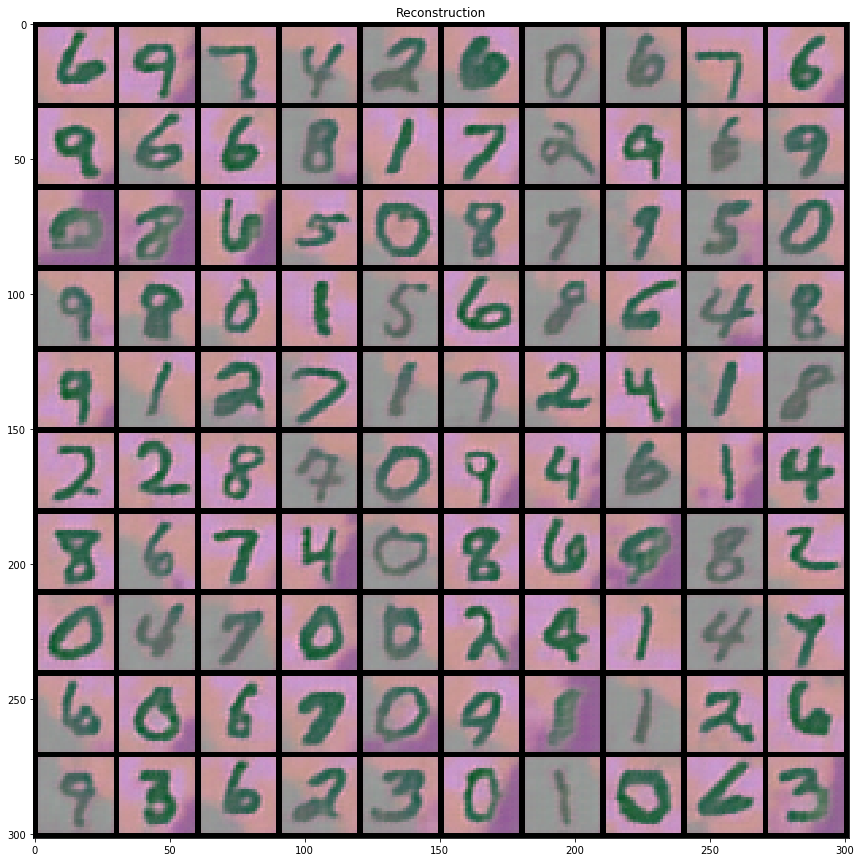

[42/50][99/600]	 loss: 0.0218	 val_loss: 0.0215	
[42/50][199/600]	 loss: 0.0215	 val_loss: 0.0214	
[42/50][299/600]	 loss: 0.0217	 val_loss: 0.0218	
[42/50][399/600]	 loss: 0.0214	 val_loss: 0.0212	
[42/50][499/600]	 loss: 0.0214	 val_loss: 0.0212	
[42/50][599/600]	 loss: 0.0222	 val_loss: 0.0222	
[43/50][99/600]	 loss: 0.0221	 val_loss: 0.0221	
[43/50][199/600]	 loss: 0.0210	 val_loss: 0.0208	
[43/50][299/600]	 loss: 0.0220	 val_loss: 0.0220	
[43/50][399/600]	 loss: 0.0215	 val_loss: 0.0214	
[43/50][499/600]	 loss: 0.0216	 val_loss: 0.0218	
[43/50][599/600]	 loss: 0.0212	 val_loss: 0.0212	


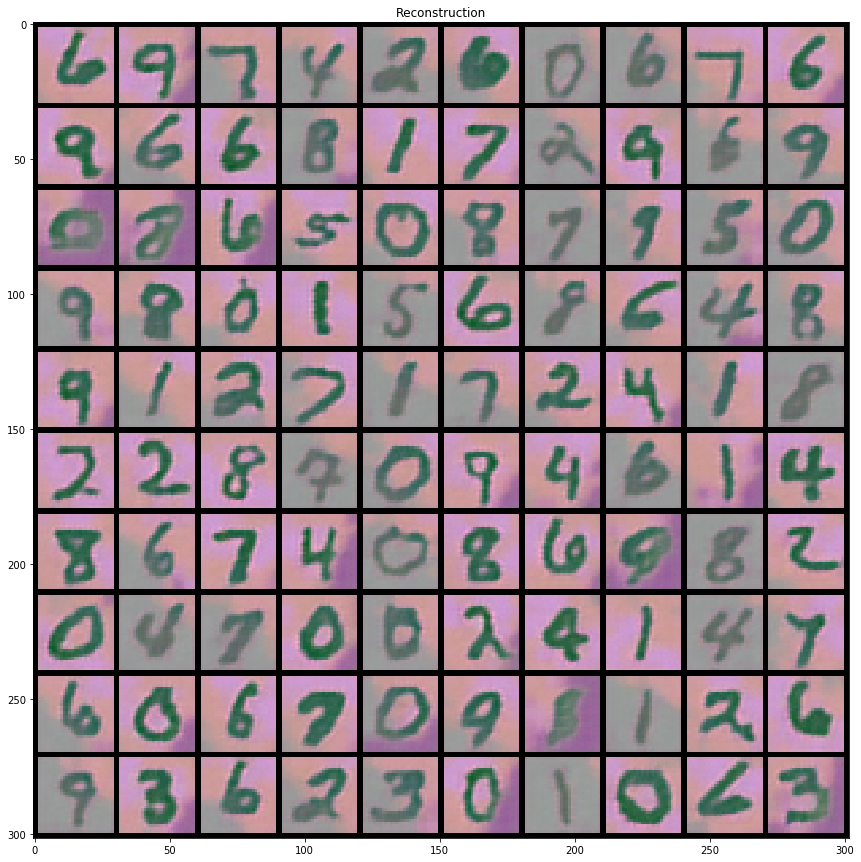

[44/50][99/600]	 loss: 0.0207	 val_loss: 0.0207	
[44/50][199/600]	 loss: 0.0218	 val_loss: 0.0217	
[44/50][299/600]	 loss: 0.0203	 val_loss: 0.0204	
[44/50][399/600]	 loss: 0.0213	 val_loss: 0.0213	
[44/50][499/600]	 loss: 0.0211	 val_loss: 0.0212	
[44/50][599/600]	 loss: 0.0214	 val_loss: 0.0214	
[45/50][99/600]	 loss: 0.0216	 val_loss: 0.0215	
[45/50][199/600]	 loss: 0.0213	 val_loss: 0.0213	
[45/50][299/600]	 loss: 0.0213	 val_loss: 0.0212	
[45/50][399/600]	 loss: 0.0207	 val_loss: 0.0206	
[45/50][499/600]	 loss: 0.0207	 val_loss: 0.0207	
[45/50][599/600]	 loss: 0.0220	 val_loss: 0.0218	


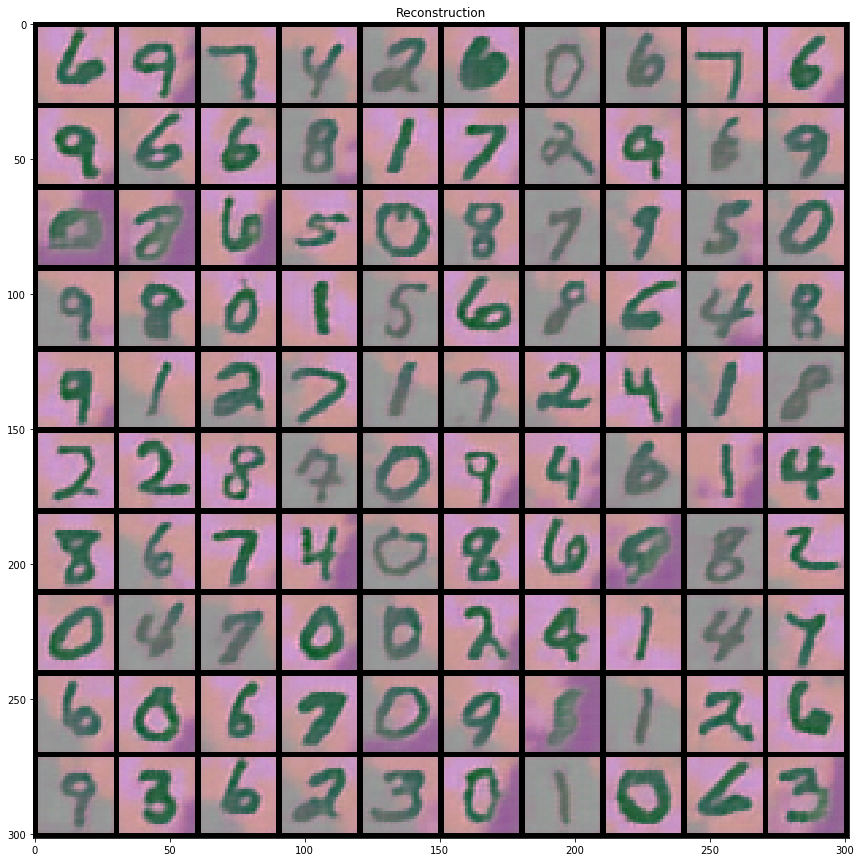

[46/50][99/600]	 loss: 0.0209	 val_loss: 0.0209	
[46/50][199/600]	 loss: 0.0209	 val_loss: 0.0209	
[46/50][299/600]	 loss: 0.0209	 val_loss: 0.0210	
[46/50][399/600]	 loss: 0.0204	 val_loss: 0.0204	
[46/50][499/600]	 loss: 0.0204	 val_loss: 0.0204	
[46/50][599/600]	 loss: 0.0207	 val_loss: 0.0208	
[47/50][99/600]	 loss: 0.0218	 val_loss: 0.0219	
[47/50][199/600]	 loss: 0.0203	 val_loss: 0.0203	
[47/50][299/600]	 loss: 0.0208	 val_loss: 0.0208	
[47/50][399/600]	 loss: 0.0207	 val_loss: 0.0206	
[47/50][499/600]	 loss: 0.0204	 val_loss: 0.0205	
[47/50][599/600]	 loss: 0.0204	 val_loss: 0.0203	


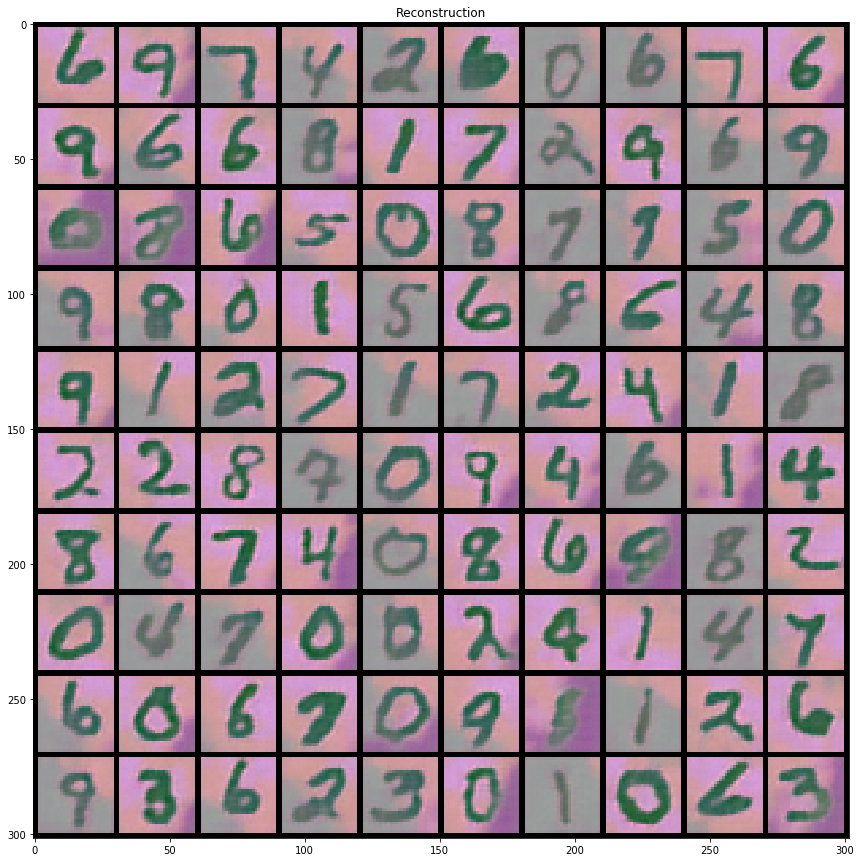

[48/50][99/600]	 loss: 0.0207	 val_loss: 0.0206	
[48/50][199/600]	 loss: 0.0204	 val_loss: 0.0204	
[48/50][299/600]	 loss: 0.0196	 val_loss: 0.0197	
[48/50][399/600]	 loss: 0.0209	 val_loss: 0.0208	
[48/50][499/600]	 loss: 0.0204	 val_loss: 0.0204	
[48/50][599/600]	 loss: 0.0205	 val_loss: 0.0208	
[49/50][99/600]	 loss: 0.0210	 val_loss: 0.0210	
[49/50][199/600]	 loss: 0.0205	 val_loss: 0.0204	
[49/50][299/600]	 loss: 0.0207	 val_loss: 0.0207	
[49/50][399/600]	 loss: 0.0203	 val_loss: 0.0201	
[49/50][499/600]	 loss: 0.0196	 val_loss: 0.0196	
[49/50][599/600]	 loss: 0.0203	 val_loss: 0.0204	


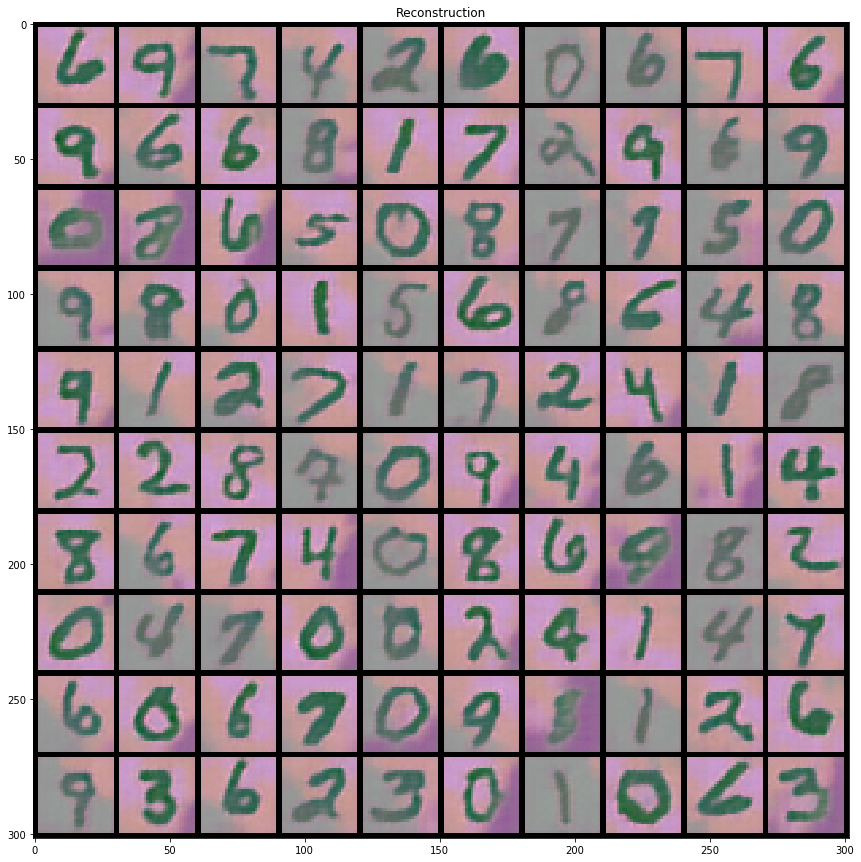

In [24]:
loss_recon = []
loss_quan = []

val_loss_recon = []
val_loss_quan = []

count = 0
for epoch in range(EPOCHS):
  for i, (x, _) in enumerate(train_loader):
    x = x.to(device)

    optimizer.zero_grad()

    x_recon, quantized, encoding_indices, vq_loss = vq_vae(x)


    recon_loss = F.mse_loss(x_recon, x)
    loss = vq_loss + recon_loss

    loss_recon.append(recon_loss.item())
    loss_quan.append(vq_loss.item())

    loss.backward()
    optimizer.step()
    
    if ((i+1) % 100 == 0):
      with torch.set_grad_enabled(False):
        x_val, _ = next(iter(test_loader))
        x_val = x_val.to(device)

        x_recon, quantized, encoding_indices, val_vq_loss = vq_vae(x)

        val_recon_loss = F.mse_loss(x_recon, x)

        val_loss = val_vq_loss + val_recon_loss

        val_loss_recon.append(val_recon_loss.item())
        val_loss_quan.append(val_vq_loss.item())

        print('[%d/%d][%d/%d]\t loss: %.4f\t val_loss: %.4f\t'
                  % (epoch, EPOCHS, i, len(train_loader),
                     loss.item(), val_loss.item()))
        
        if ((count+1) % 1200 == 0):
          reconstruction = generate_samples(fixed_images, vq_vae)
          grid = make_grid(reconstruction.cpu(), nrow=10, normalize=True)
          
          fig = plt.figure(figsize=(15,15))
          plt.imshow(np.transpose(grid, (1,2,0)), cmap="gray")
          plt.title("Reconstruction")
          plt.show()
    count += 1

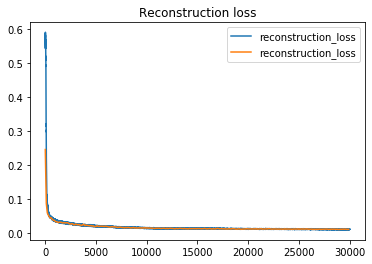

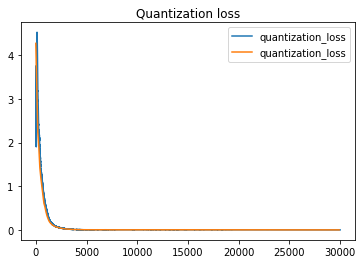

In [25]:
plt.title("Reconstruction loss")
plt.plot(loss_recon, label = "reconstruction_loss")
plt.plot(np.arange(0, len(loss_recon),int(len(loss_recon)/len(val_loss_recon))),val_loss_recon, label = "reconstruction_loss")
plt.legend()
plt.show()

plt.title("Quantization loss")
plt.plot(loss_quan, label = "quantization_loss")
plt.plot(np.arange(0, len(loss_quan),int(len(loss_quan)/len(val_loss_quan))),val_loss_quan, label = "quantization_loss")
plt.legend()
plt.show()

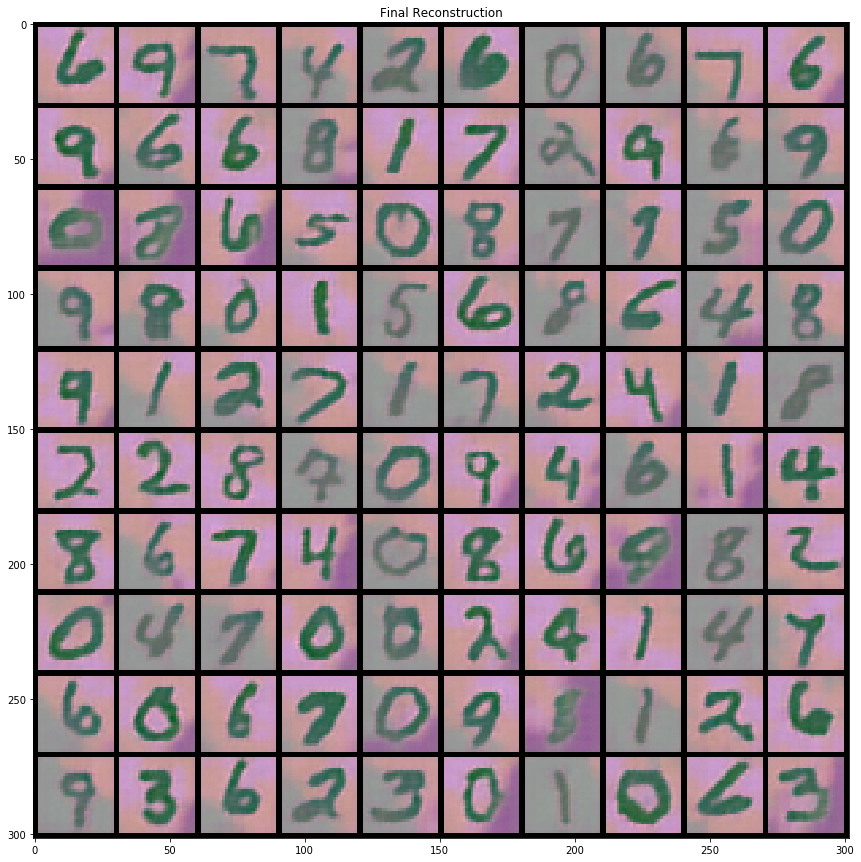

In [26]:
# save model
torch.save(vq_vae.state_dict(), 'models/{}_vqvae.pt'.format("mnist"))


# plot last recon
reconstruction = generate_samples(fixed_images, vq_vae)
grid = make_grid(reconstruction.cpu(), nrow=10, normalize=True)
fig = plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)), cmap="gray")
plt.title("Final Reconstruction")
plt.show()

## Load VQ-VAE 

In [27]:
# vq_vae = VectorQuantizedVAE(3, 64, num_embeddings).to(device)

# vq_vae.load_state_dict(torch.load('models/{}_vqvae.pt'.format("mnist")))

In [28]:
def convert_dataset(model, dataset, batch_size):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_indices = []
    all_y = []
    model.eval()
    for x, y in dataloader:
        x = x.to(device)
        with torch.no_grad():
            z = model.encode(x)
            quantized, indices, _ = model.quantize(z)
        all_indices.append(indices)
        all_y.append(y)
    
    indices = torch.cat(all_indices, dim=0)
    y = torch.cat(all_y, dim=0)
    return torch.utils.data.TensorDataset(indices, y)

In [29]:
z_train_dataset = convert_dataset(vq_vae, trainset, batch_size=100)
z_test_dataset = convert_dataset(vq_vae, testset, batch_size=100)

In [30]:
class GatedActivation(nn.Module):
  
  def __init__(self):
    super().__init__()
  
  def forward(self, x):
    x, y = x.chunk(2, dim=1)
    return torch.tanh(x) * torch.sigmoid(y)


class GatedMaskedConv2d(nn.Module):
    
  def __init__(self, mask_type, hidden_channels, kernel_size, residual, num_classes):
    super().__init__()
    self.mask_type = mask_type
    self.residual = residual
    
    h = hidden_channels
    
    self.class_cond_embedding = nn.Embedding(num_classes, h * 2)
    
    self.vert_stack = nn.Conv2d(
        h, h * 2, kernel_size=(kernel_size // 2 + 1, kernel_size), stride=1,
        padding=(kernel_size // 2, kernel_size // 2)
    )
    self.vert_to_horiz = nn.Conv2d(h * 2, h * 2, kernel_size=1, stride=1, padding=0)
    self.horiz_stack = nn.Conv2d(h, h * 2, kernel_size=(1, kernel_size // 2 + 1), stride=1,
                                  padding=(0, kernel_size // 2))
    self.horiz_resid = nn.Conv2d(h, h, kernel_size=1, stride=1, padding=0)
    
    self.gate = GatedActivation()
  
  def make_causal(self):
    self.vert_stack.weight.data[:, :, -1].zero_()  # mask final row
    self.horiz_stack.weight.data[:, :, :, -1].zero_()  # mask final column
  
  def forward(self, x_v, x_h, h):
    if self.mask_type == 'A':
        self.make_causal()
    
    h = self.class_cond_embedding(h)
    h_vert = self.vert_stack(x_v)
    h_vert = h_vert[:, :, :x_v.size(-1), :]
    out_v = self.gate(h_vert + h[:, :, None, None])
    
    h_horiz = self.horiz_stack(x_h)
    h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
    v2h = self.vert_to_horiz(h_vert)
    
    out = self.gate(v2h + h_horiz + h[:, :, None, None])
    if self.residual:
        out_h = self.horiz_resid(out) + x_h
    else:
        out_h = self.horiz_resid(out)
    
    return out_v, out_h


class GatedPixelCNN(nn.Module):
    
  def __init__(self, num_classes, in_channels, hidden_channels, output_channels, num_layers):
    super().__init__()
    self.num_classes = num_classes
    
    self.embedding = nn.Embedding(in_channels, hidden_channels)
    
    self.mask_a = GatedMaskedConv2d('A', hidden_channels, kernel_size=7,
                                    residual=False, num_classes=num_classes)
    self.mask_bs = nn.ModuleList([
        GatedMaskedConv2d('B', hidden_channels, kernel_size=3,
                          residual=True, num_classes=num_classes) for _ in range(num_layers - 1)])
    
    self.output_conv = nn.Sequential(
        nn.Conv2d(hidden_channels, output_channels, 1),
        nn.ReLU(inplace=True),
        nn.Conv2d(output_channels, in_channels, kernel_size=1, stride=1, padding=0)
    )
  
  def forward(self, x, y):
    x = self.embedding(x.view(-1)).view(x.shape + (-1,))  # (B, H, W, C)
    x = x.permute(0, 3, 1, 2)  # (B, C, H, W)
    
    x_v, x_h = self.mask_a(x, x, y)
    for mask_b in self.mask_bs:
        x_v, x_h = mask_b(x_v, x_h, y)
    
    return self.output_conv(x_h)

  def sample(self, batch_size, shape, label=None):
    self.eval()
    
    x = torch.zeros((batch_size, *shape), dtype=torch.long, device=device)
    if label is None:
        label = torch.randint(self.num_classes, (batch_size,), dtype=torch.long, device=device)
    
    with torch.no_grad():
        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x, label)
                dist = Categorical(logits=logits[:, :, i, j])
                x[:, i, j] = dist.sample()
    return x

In [31]:
in_channels = vq_vae.num_embeddings
# num_classes, in_channels, hidden_channels, output_channels, num_layers
pixel_cnn = GatedPixelCNN(10, in_channels, 64, 512, 12)
pixel_cnn.to(device)
    
optimizer = optim.Adam(pixel_cnn.parameters(), lr=1e-3, weight_decay=decay)

In [32]:
dataloader = torch.utils.data.DataLoader(z_train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(z_train_dataset, batch_size=batch_size, shuffle=True)


In [ ]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
  for i, (x, y) in enumerate(dataloader):
    x = x.to(device).squeeze(dim=1)
    y = y.to(device)
    
    optimizer.zero_grad()
    out = pixel_cnn(x, y)
    scores = out.permute(0, 2, 3, 1).reshape(-1, in_channels)
    
    loss = F.cross_entropy(scores, x.view(-1))

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    
    if ((i+1) % 100 == 0):
      with torch.set_grad_enabled(False):
        x, y = next(iter(val_dataloader))
        x = x.to(device).squeeze(dim=1)
        y = y.to(device)

        out = pixel_cnn(x, y)
        scores = out.permute(0, 2, 3, 1).reshape(-1, in_channels)
        val_loss = F.cross_entropy(scores, x.view(-1))

        val_losses.append(val_loss.item())
  
        print('[%d/%d][%d/%d]\t loss: %.4f\t val_loss: %.4f\t'
                  % (epoch, EPOCHS, i, len(train_loader),
                     loss.item(), val_loss.item()))


[0/50][99/600]	 loss: 2.0300	 val_loss: 2.0602	
[0/50][199/600]	 loss: 1.8938	 val_loss: 1.8612	
[0/50][299/600]	 loss: 1.8095	 val_loss: 1.8715	
[0/50][399/600]	 loss: 1.7921	 val_loss: 1.8003	
[0/50][499/600]	 loss: 1.7439	 val_loss: 1.7111	
[0/50][599/600]	 loss: 1.7040	 val_loss: 1.7215	
[1/50][99/600]	 loss: 1.6867	 val_loss: 1.7212	
[1/50][199/600]	 loss: 1.6437	 val_loss: 1.6834	
[1/50][299/600]	 loss: 1.6727	 val_loss: 1.6450	
[1/50][399/600]	 loss: 1.6350	 val_loss: 1.6363	
[1/50][499/600]	 loss: 1.6579	 val_loss: 1.6142	
[1/50][599/600]	 loss: 1.6392	 val_loss: 1.5682	
[2/50][99/600]	 loss: 1.5912	 val_loss: 1.6195	
[2/50][199/600]	 loss: 1.5790	 val_loss: 1.5978	
[2/50][299/600]	 loss: 1.5668	 val_loss: 1.5797	
[2/50][399/600]	 loss: 1.6001	 val_loss: 1.5743	
[2/50][499/600]	 loss: 1.5524	 val_loss: 1.5409	
[2/50][599/600]	 loss: 1.6085	 val_loss: 1.5696	
[3/50][99/600]	 loss: 1.5774	 val_loss: 1.6112	
[3/50][199/600]	 loss: 1.5651	 val_loss: 1.5580	
[3/50][299/600]	 loss: 1

In [ ]:
plt.title("loss")
plt.plot(train_losses, label = "loss")
plt.plot(np.arange(0, len(train_losses),int(len(train_losses)/len(val_losses))),val_losses, label = "reconstruction_loss")
plt.legend()
plt.show()

In [ ]:
class PixelCNNVQVAE(nn.Module):
    
    def __init__(self, pixelcnn, vqvae, latent_height, latent_width):
        super().__init__()
        self.pixelcnn = pixelcnn
        self.vqvae = vqvae
        self.latent_height = latent_height
        self.latent_width = latent_width
    
    def sample_prior(self, batch_size, label=None):
        indices = self.pixelcnn.sample(batch_size, (self.latent_height, self.latent_width), label).squeeze(dim=1)
        
        self.vqvae.eval()
        with torch.no_grad():
            quantized = self.vqvae.embed(indices).permute(0, 3, 1, 2)
        
        return quantized, indices
    
    def sample(self, batch_size, label=None):
        quantized, indices = self.sample_prior(batch_size, label)
        with torch.no_grad():
            x_recon = self.vqvae.decode(quantized)
        return x_recon, quantized, indices

In [ ]:
model = PixelCNNVQVAE(pixel_cnn, vq_vae, 7, 7)

In [ ]:
x_recon, quantized, indices = model.sample(100)

grid = make_grid(x_recon.cpu(), nrow=10, normalize=True)
          
fig = plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)), cmap="gray")
plt.title("Reconstruction")
plt.show()

In [ ]:
x_recon = torch.cat([model.sample(8, label=torch.full((8,), i, dtype=torch.long, device=device))[0]
                     for i in range(10)], dim=0)

grid = make_grid(x_recon.cpu(), nrow=8, normalize=True)
          
fig = plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)), cmap="gray")
plt.title("Reconstruction")
plt.show()

In [ ]:
# save model
torch.save(pixel_cnn.state_dict(), 'models/{}_pixel_cnn.pt'.format("mnist"))